In [1]:
import refinitiv.data as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD

2024-12-16 07:41:49.599782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load dataset

In [2]:
security = 'SGD='
date_0 = '2019-11-01'
date_1 = '2024-12-01'

rd.open_session()
markets = rd.get_history(universe=[security], fields=['MID_PRICE'],
                         interval="1d", start=date_0, end=date_1
                    )

df = markets

train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

Manage data format and scales

In [3]:
dataset_train = train.MID_PRICE.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test.MID_PRICE.values
dataset_test = np.reshape(dataset_test, (-1,1))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)

Divide time series into a supervised learning problem.  
It's meant to say that the first 49 observation, determined the value in 50th.

In [4]:
x_train = []
y_train = []
for i in range(50, len(scaled_train)):
    x_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])
    
x_test = []
y_test = []
for i in range(50, len(scaled_test)):
    x_test.append(scaled_test[i-50:i, 0])
    y_test.append(scaled_test[i, 0])


Reshaping for Neural Network Model

In [5]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

Gated Recurrent Unit RNN Model

In [6]:
# Initialise
regressor = Sequential()

# RNN layers and dropout regularisation
regressor.add(GRU(units = 50,
                       activation = 'tanh',
                       return_sequences = True,
                       input_shape = (x_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(GRU(units = 50,
                       activation = 'tanh',
                       return_sequences = True))
regressor.add(GRU(units = 50,
                       activation = 'tanh',
                       return_sequences = True))
regressor.add(GRU(units = 50))

# Output layer
regressor.add(Dense(units = 1, activation = 'relu'))

# Compile RNN
regressor.compile(optimizer = 
                  SGD(learning_rate = 0.01,
                     decay=1e-7,
                     momentum=0.9,
                     nesterov=False),
                 loss = 'mean_squared_error')

# Fit RNN
regressor.fit(x_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()

2024-12-16 07:42:06.260653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
505/505 [==============================] - 34s 56ms/step - loss: 0.0111
Epoch 2/20
505/505 [==============================] - 30s 60ms/step - loss: 0.0038
Epoch 3/20
505/505 [==============================] - 29s 57ms/step - loss: 0.0037
Epoch 4/20
505/505 [==============================] - 30s 59ms/step - loss: 0.0035
Epoch 5/20
505/505 [==============================] - 30s 59ms/step - loss: 0.0032
Epoch 6/20
505/505 [==============================] - 30s 60ms/step - loss: 0.0029
Epoch 7/20
505/505 [==============================] - 30s 59ms/step - loss: 0.0027
Epoch 8/20
505/505 [==============================] - 31s 61ms/step - loss: 0.0027
Epoch 9/20
505/505 [==============================] - 30s 59ms/step - loss: 0.0025
Epoch 10/20
505/505 [==============================] - 30s 60ms/step - loss: 0.0024
Epoch 11/20
505/505 [==============================] - 30s 60ms/step - loss: 0.0024
Epoch 12/20
505/505 [==============================] - 29s 58ms/step - loss: 0.0021
E

7/7 [==============================] - 2s 26ms/step


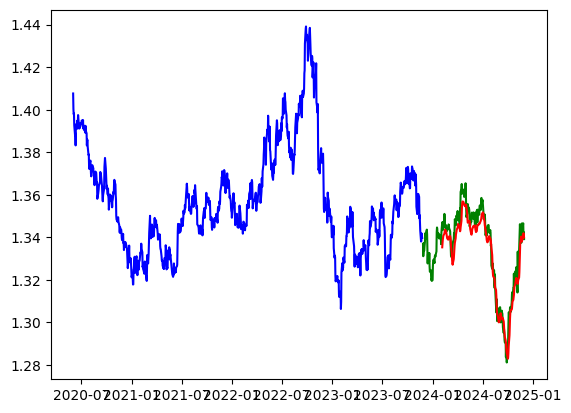

In [7]:
y_GRU = regressor.predict(x_test)
y_GRU_O = scaler.inverse_transform(y_GRU)

plt.plot(train.index[150:], train[150:].values, label="train", color='b')
plt.plot(test.index, test.values, label='test', color = 'g')
plt.plot(test.index[50:], y_GRU_O, label='GRU', color = 'r')
plt.show()

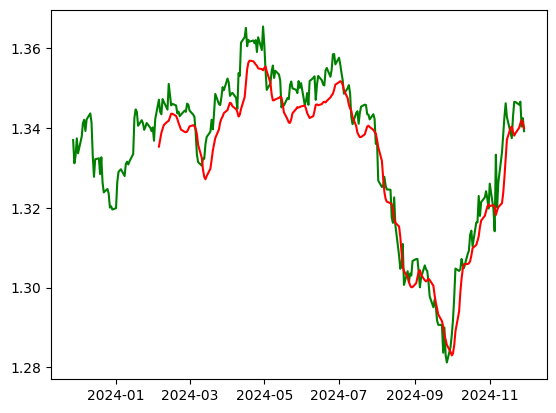

In [9]:
plt.plot(test.index, test.values, label='test', color = 'g')
plt.plot(test.index[50:], y_GRU_O, label='GRU', color = 'r')
plt.show()